#### 1. Preparing Dataset


In [26]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [15]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Reshape to 3 channels and normalize
train_images = np.stack([train_images]*3, axis=-1) / 255.0
test_images = np.stack([test_images]*3, axis=-1) / 255.0

# Resize images to 32x32
train_images = tf.image.resize(train_images, [32, 32])
test_images = tf.image.resize(test_images, [32, 32])

# Convert labels to one-hot encoding
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

#### Step 2: Building the Model

1. Load MobileNetV2 with pre-trained weights from ImageNet, excluding the fully connected top layers to customize for our 10-class classification task:

2. Freeze the base model to retain learned features and avoid overfitting.
3. Add a global average pooling layer to reduce model complexity.
4. Add a dense layer with softmax activation for the output classes.

In [16]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

In [17]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
base_model.trainable = False  # Freeze base model

inputs = Input(shape=(32, 32, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
outputs = Dense(10, activation='softmax')(x)
model = Model(inputs, outputs)

/tmp/ipykernel_7162/1327929872.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


#### Step 3: Compiling and Training the Model


In [18]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=10, validation_split=0.2)

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.4512 - loss: 1.8307 - val_accuracy: 0.6060 - val_loss: 1.2955
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.6085 - loss: 1.2596 - val_accuracy: 0.6388 - val_loss: 1.1381
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.6327 - loss: 1.1370 - val_accuracy: 0.6528 - val_loss: 1.0723
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.6476 - loss: 1.0763 - val_accuracy: 0.6601 - val_loss: 1.0361
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.6561 - loss: 1.0481 - val_accuracy: 0.6658 - val_loss: 1.0145
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.6568 - loss: 1.0254 - val_accuracy: 0.6683 - val_loss: 0.9997
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.6615 - loss: 1.0159 - val_accuracy: 0.6680 - val_loss: 0.9898
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.6630 -

#### Step 4: Fine-Tuning the Model

 We unfreeze the last few layers of the base model to perform fine-tuning.

In [19]:
base_model.trainable = True

for layer in base_model.layers[:100]:
    layer.trainable = False

In [20]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),loss='categorical_crossentropy',
              metrics = ['accuracy']
)

In [22]:
model.fit(train_images, train_labels, epochs=5, validation_split=0.2)

Epoch 1/5


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 99s 63ms/step - accuracy: 0.2298 - loss: 11.0146 - val_accuracy: 0.1614 - val_loss: 9.2379
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 96s 64ms/step - accuracy: 0.4703 - loss: 2.8031 - val_accuracy: 0.2422 - val_loss: 2.4589
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 105s 70ms/step - accuracy: 0.5928 - loss: 1.6324 - val_accuracy: 0.6568 - val_loss: 1.1114
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 108s 72ms/step - accuracy: 0.6858 - loss: 1.1299 - val_accuracy: 0.8020 - val_loss: 0.7021
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 109s 73ms/step - accuracy: 0.7533 - loss: 0.8647 - val_accuracy: 0.8482 - val_loss: 0.5368


#### Step 5: Model Evaluation

In [23]:
loss, accuracy = model.evaluate(test_images, test_labels)

print(f"Test Loss : {loss}")
print(f"Test Accuracy : {accuracy}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8321 - loss: 0.5930
Test Loss : 0.5534537434577942
Test Accuracy : 0.8464000225067139


#### Step 6: Visualizing Model Performance

In [27]:
test_predictions = model.predict(test_images)
test_predictions_classes = np.argmax(test_predictions, axis=1)
test_true_classes = np.argmax(test_labels, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step


Text(0.5, 1.0, 'Confusion Matrix')

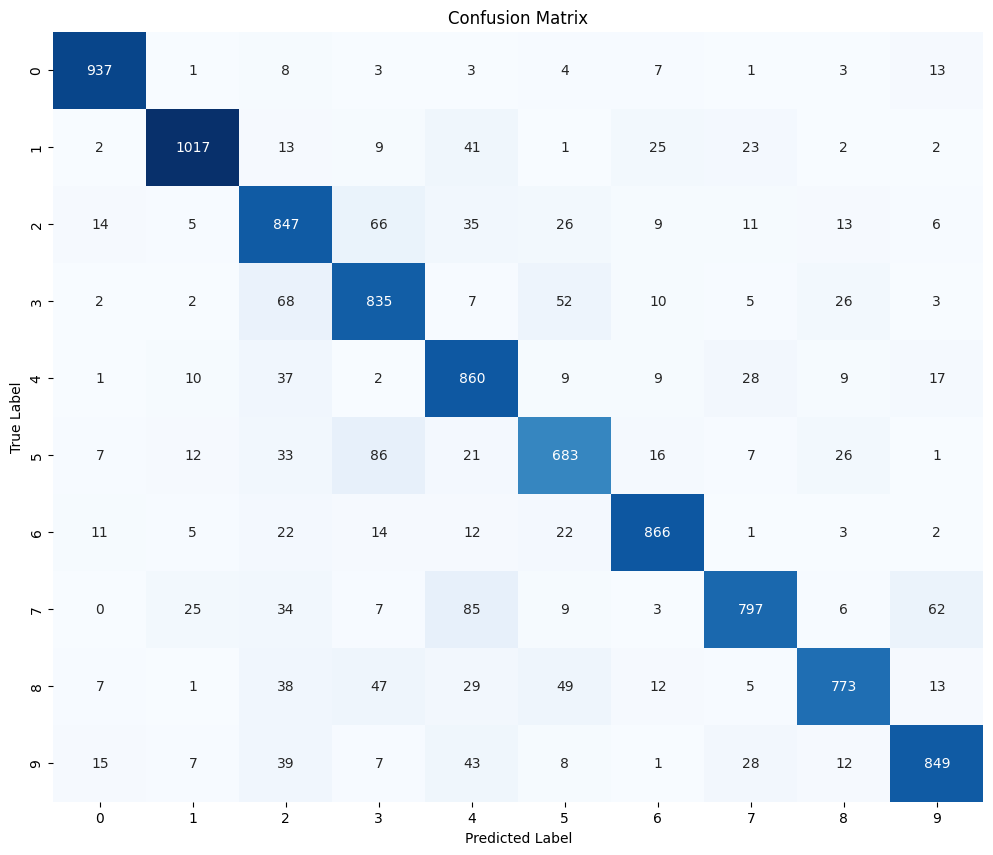

In [28]:
cm = confusion_matrix(test_true_classes, test_predictions_classes)
plt.figure(figsize=(12, 10))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

#### Step 7: Sample Image Visualization


In [31]:
def display_sample(sample_images, sample_labels, sample_predictions):
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

    for i, ax in enumerate(axes.flat):
        ax.imshow(sample_images[i].reshape(32, 32), cmap='gray')
        ax.set_xlabel(f"True: {sample_labels[i]}\nPredicted: {sample_predictions[i]}")
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

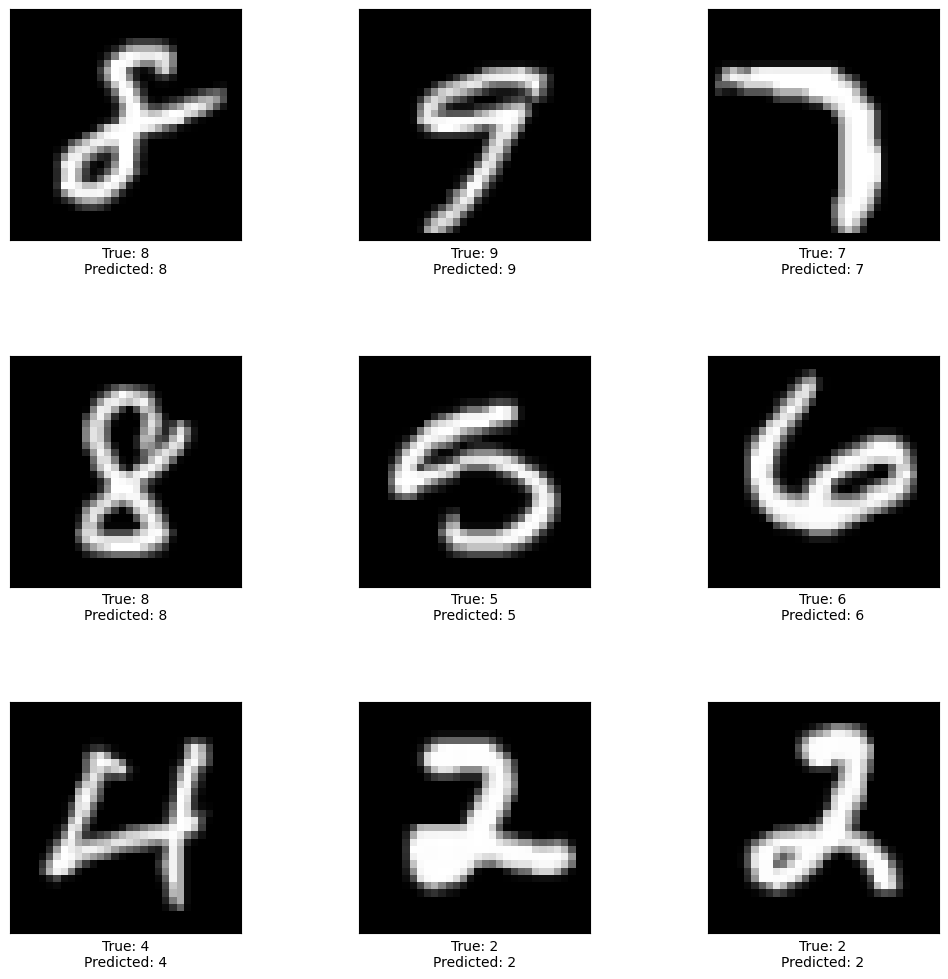

In [30]:
# Convert RGB to grayscale for visualization
test_images_gray = np.dot(test_images[...,:3], [0.2989, 0.5870, 0.1140])

random_indices = np.random.choice(len(test_images_gray), 9, replace=False)
sample_images = test_images_gray[random_indices]
sample_labels = test_true_classes[random_indices]
sample_predictions = test_predictions_classes[random_indices]
display_sample(sample_images, sample_labels, sample_predictions)